In [62]:
import pandas as pd
from pymongo import MongoClient
from pymongo.errors import ConnectionFailure, ConfigurationError
import dotenv, re, os
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [2]:
dotenv.load_dotenv()

# Les collections
client       = MongoClient(os.environ["MONGO_URL"])
user         = client['RemiGOAT']['UserData']
message      = client['RemiGOAT']['Message']
Session      = client['RemiGOAT']['Session']
sessionUser  = client['RemiGOAT']['SessionByUser']

In [3]:
def _connect_mongo(host, port, db, username=None, password=None, **kwargs):
    """ A utility for making a connection to MongoDB. """
    try:
        if username and password:
            mongo_uri = f'mongodb://{username}:{password}@{host}:{port}/{db}'
            conn = MongoClient(mongo_uri, **kwargs)
        else:
            conn = MongoClient(host, port, **kwargs)
        conn.admin.command('ping')
        return conn[db]
    except (ConnectionFailure, ConfigurationError) as e:
        print(f"Failed to connect to MongoDB: {e}")
        raise

def read_mongo(db, collection, query={}, host='localhost', port=27017, username=None, password=None, no_id=True, 
               join_collection=None, local_field=None, foreign_field=None, as_field=None, 
               output_collection=None, **kwargs):
    """ Read from MongoDB, optionally join with another collection, and store into DataFrame. """
    try:
        db_conn = _connect_mongo(host=host, port=port, username=username, password=password, db=db, **kwargs)
        if join_collection and local_field and foreign_field and as_field:
            pipeline = [
                {"$match": query},
                {
                    "$lookup": {
                        "from": join_collection,
                        "localField": local_field,
                        "foreignField": foreign_field,
                        "as": as_field
                    }
                }
            ]
            cursor = db_conn[collection].aggregate(pipeline)
        else:
            cursor = db_conn[collection].find(query)
        df = pd.DataFrame(list(cursor))
        if no_id and '_id' in df.columns:
            df.drop('_id', axis=1, inplace=True)
        if output_collection:
            db_conn[output_collection].insert_many(df.to_dict('records'))
        return df
    except Exception as e:
        print(f"An error occurred: {e}")
        raise

In [4]:

dfmessage = read_mongo(
    db='RemiGOAT',
    collection='MessageUser',
    query={},  # On filtre les messages où IsEval est True
    host='localhost',
    port=27017,
    username=None,
    password=None,
    join_collection='Session',
    local_field='course_id',
    foreign_field='session',
    as_field='session_details',
)
dfmessage

,message_id,parent_id,thread_id,thread_type,title,context,courseware_title,course_id,username,body,type,created_at,updated_at,vote_down_count,vote_up_count,vote_point,vote_count,session_details
0,52ef4b71ab137b00720007d4,52ef4b71ab137b00720007d4,52ef4b71ab137b00720007d4,discussion,Jeune Ingénieur,course,Entre nous / Presentez-vous,CNAM/01002/Trimestre_1_2014,qb,Dans le cadre de mes études d'ingénieur j'ai é...,thread,2014-02-03T07:55:29Z,2014-02-03T07:55:29Z,0,1,1,1,"[{'_id': 6655d14eb56c816808d5c898, 'session': ..."
1,52ef5f60919cec5e32000962,52ef4b71ab137b00720007d4,52ef4b71ab137b00720007d4,NaN,NaN,NaN,NaN,CNAM/01002/Trimestre_1_2014,MountacirAmar,jeune ingénieur occupant le post d'un Project ...,comment,2014-02-03T09:20:32Z,2014-02-03T09:20:32Z,0,0,0,0,"[{'_id': 6655d14eb56c816808d5c898, 'session': ..."
2,52ef4d79b4907d2e23000996,52ef4d79b4907d2e23000996,52ef4d79b4907d2e23000996,discussion,Appronfondir mes connaissances,course,Entre nous / Presentez-vous,CNAM/01002/Trimestre_1_2014,fidji,"Bonjour,\nje suis actuellement une formation d...",thread,2014-02-03T08:04:09Z,2014-02-03T08:04:09Z,0,0,0,0,"[{'_id': 6655d14eb56c816808d5c898, 'session': ..."
3,52ef73945c4baf9e610008a8,52ef4d79b4907d2e23000996,52ef4d79b4907d2e23000996,NaN,NaN,NaN,NaN,CNAM/01002/Trimestre_1_2014,ElenaThomas,"Bonjour, fondatrice du l’Institut Européen pou...",comment,2014-02-03T10:46:44Z,2014-02-03T10:46:44Z,0,0,0,0,"[{'_id': 6655d14eb56c816808d5c898, 'session': ..."
4,52efa3b5cfc81d7e410009a3,52ef73945c4baf9e610008a8,52ef4d79b4907d2e23000996,NaN,NaN,NaN,NaN,CNAM/01002/Trimestre_1_2014,BEJA,"Répartir les taches, former ses collaborateurs...",comment,2014-02-03T14:12:05Z,2014-02-03T14:12:05Z,0,0,0,0,"[{'_id': 6655d14eb56c816808d5c898, 'session': ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169608,62b431ef84854e0001000044,62b431ef84854e0001000044,62b431ef84854e0001000044,discussion,J'ai trouvé moyen d'améliorer la fin du code,course,Semaine 2 / Les capteurs,course-v1:MinesTelecom+04017+session12,ClemGamer,J'ai trouvé moyen d'améliorer la fin du code. ...,thread,2022-06-23T09:27:11Z,2022-06-23T18:56:10Z,0,0,0,0,"[{'_id': 6655d14fb56c816808d5d65a, 'session': ..."
169609,62b4b74a39ed9e0001000082,62b431ef84854e0001000044,62b431ef84854e0001000044,NaN,NaN,NaN,NaN,course-v1:MinesTelecom+04017+session12,EGo41,"Bonjour, \nEt à quoi sert la ligne 2 alors, q...",comment,2022-06-23T18:56:10Z,2022-06-23T18:56:10Z,0,0,0,0,"[{'_id': 6655d14fb56c816808d5d65a, 'session': ..."
169610,62b747c7d8cfb40001000065,62b747c7d8cfb40001000065,62b747c7d8cfb40001000065,discussion,Visite D'un FabLab,course,Semaine 1 / Les objets et projets des FabLabs,course-v1:MinesTelecom+04026+session10,andeffofossi,Je n'est pas compris la carte .\nJe suis dans ...,thread,2022-06-25T17:37:11Z,2022-06-25T17:37:11Z,0,0,0,0,"[{'_id': 6655d153b56c816808d60efd, 'session': ..."
169611,62b89f768cfc560001000065,62b89f768cfc560001000065,62b89f768cfc560001000065,discussion,TP,course,Semaine 2 / Partagez vos modélisations Tinkercad,course-v1:MinesTelecom+04021+session12,ClemGamer,https://www.tinkercad.com/things/8XFiMDO5GfY,thread,2022-06-26T18:03:34Z,2022-06-26T18:03:34Z,0,0,0,0,"[{'_id': 6655d153b56c816808d60eff, 'session': ..."


In [5]:
dfusers = read_mongo(
    db='RemiGOAT',
    collection='UserData',
    query={},  # On filtre les messages où IsEval est True
    host='localhost',
    port=27017,
    username=None,
    password=None,
)
dfusers

,username,id,city,country,gender,level_of_education,email,CSP,year_of_birth,csp
0,jirasrideslis,58d571786d4d80c00f9c1465,None,,None,None,jirasri.deslis@fun-mooc.fr,None,None,NaN
1,Osiatis_FUN,58d571786d4d80c00f9c1466,Grenoble,FR,m,hs,assistance.at.fun@gmail.com,None,1985,NaN
2,EllaHamonic,58d571786d4d80c00f9c1467,Paris,FR,f,m,ella.hamonic@mines-telecom.fr,"Cadre, sup",1989,NaN
3,DelphineLalire,58d571786d4d80c00f9c1468,None,,f,m,delphine.lalire@mines-telecom.fr,None,1972,NaN
4,baptistegaultier,58d571786d4d80c00f9c1469,None,,None,None,baptiste.gaultier@telecom-bretagne.eu,None,None,NaN
...,...,...,...,...,...,...,...,...,...,...
112386,Ronzephir,62d799e873c4e45c2dd685a1,None,None,None,None,None,None,None,NaN
112387,Valerie_Hd,62d799e873c4e45c2dd685a3,None,None,None,None,None,None,None,NaN
112388,lilite5,62d799e873c4e45c2dd685a5,None,None,None,None,None,None,None,NaN
112389,None,NaN,None,None,m,None,None,"Cadre, sup",None,NaN


In [6]:
dfgrades = read_mongo(
    db='RemiGOAT',
    collection='SessionUser',
    query={},  # On filtre les messages où IsEval est True
    host='localhost',
    port=27017,
    username=None,
    password=None,
)
dfgrades

,username,idUser,session,Certificate Delivered,Certificate Eligible,Certificate Type,Enrollment Track,date_grade_report,grade,Verification Status,date_problem_grade_report,Cohort Name
0,jirasrideslis,58d571786d4d80c00f9c1465,MinesTelecom/04017/session01,N,N,N/A,honor,2016-05-30-1427,0.0,N/A,NaN,NaN
1,jirasrideslis,58d571786d4d80c00f9c1465,MinesTelecom/04017S02/session02,N,N,N/A,honor,2017-03-29-2201,0.0,N/A,2017-03-11-1848,NaN
2,jirasrideslis,58d571786d4d80c00f9c1465,MinesTelecom/04018/session01,N,N,N/A,honor,2016-07-20-1511,0.0,N/A,NaN,NaN
3,jirasrideslis,58d571786d4d80c00f9c1465,MinesTelecom/04018S02/session02,N,N,N/A,honor,2017-04-12-2129,0.0,N/A,NaN,NaN
4,jirasrideslis,58d571786d4d80c00f9c1465,MinesTelecom/04021/session01,N,N,N/A,honor,2016-12-12-0855,0.0,N/A,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
193225,leopold_tambour,62d799e873c4e45c2dd6859d,course-v1:centrepompidou+167002+session01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193226,Abla2020,62d799e873c4e45c2dd6859f,course-v1:centrepompidou+167002+session01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193227,Ronzephir,62d799e873c4e45c2dd685a1,course-v1:centrepompidou+167002+session01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193228,Valerie_Hd,62d799e873c4e45c2dd685a3,course-v1:centrepompidou+167002+session01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Fusionner les deux DataFrames sur la colonne "username"
df_merged_1 = pd.merge(dfmessage, dfusers, on='username', how='inner')

In [9]:
df_merged_1

,message_id,parent_id,thread_id,thread_type,title,context,courseware_title,course_id,username,body,...,session_details,id,city,country,gender,level_of_education,email,CSP,year_of_birth,csp
0,52ef4b71ab137b00720007d4,52ef4b71ab137b00720007d4,52ef4b71ab137b00720007d4,discussion,Jeune Ingénieur,course,Entre nous / Presentez-vous,CNAM/01002/Trimestre_1_2014,qb,Dans le cadre de mes études d'ingénieur j'ai é...,...,"[{'_id': 6655d14eb56c816808d5c898, 'session': ...",5a5394f4e5824b3abd3b4ea8,None,None,None,None,None,None,None,NaN
1,52ef5f60919cec5e32000962,52ef4b71ab137b00720007d4,52ef4b71ab137b00720007d4,NaN,NaN,NaN,NaN,CNAM/01002/Trimestre_1_2014,MountacirAmar,jeune ingénieur occupant le post d'un Project ...,...,"[{'_id': 6655d14eb56c816808d5c898, 'session': ...",5a5394f4e5824b3abd3b4e5d,None,None,None,None,None,None,None,NaN
2,52ef4d79b4907d2e23000996,52ef4d79b4907d2e23000996,52ef4d79b4907d2e23000996,discussion,Appronfondir mes connaissances,course,Entre nous / Presentez-vous,CNAM/01002/Trimestre_1_2014,fidji,"Bonjour,\nje suis actuellement une formation d...",...,"[{'_id': 6655d14eb56c816808d5c898, 'session': ...",5a5394f4e5824b3abd3b4ea5,None,None,None,None,None,None,None,NaN
3,52ef73945c4baf9e610008a8,52ef4d79b4907d2e23000996,52ef4d79b4907d2e23000996,NaN,NaN,NaN,NaN,CNAM/01002/Trimestre_1_2014,ElenaThomas,"Bonjour, fondatrice du l’Institut Européen pou...",...,"[{'_id': 6655d14eb56c816808d5c898, 'session': ...",58ff48ae88d1216b89e59da1,None,None,None,None,None,None,None,NaN
4,52efa3b5cfc81d7e410009a3,52ef73945c4baf9e610008a8,52ef4d79b4907d2e23000996,NaN,NaN,NaN,NaN,CNAM/01002/Trimestre_1_2014,BEJA,"Répartir les taches, former ses collaborateurs...",...,"[{'_id': 6655d14eb56c816808d5c898, 'session': ...",5a5394f4e5824b3abd3b4e23,None,None,None,None,None,None,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169608,62b431ef84854e0001000044,62b431ef84854e0001000044,62b431ef84854e0001000044,discussion,J'ai trouvé moyen d'améliorer la fin du code,course,Semaine 2 / Les capteurs,course-v1:MinesTelecom+04017+session12,ClemGamer,J'ai trouvé moyen d'améliorer la fin du code. ...,...,"[{'_id': 6655d14fb56c816808d5d65a, 'session': ...",62b864c95eb901d30ae7fb8a,None,None,None,None,None,None,None,NaN
169609,62b4b74a39ed9e0001000082,62b431ef84854e0001000044,62b431ef84854e0001000044,NaN,NaN,NaN,NaN,course-v1:MinesTelecom+04017+session12,EGo41,"Bonjour, \nEt à quoi sert la ligne 2 alors, q...",...,"[{'_id': 6655d14fb56c816808d5d65a, 'session': ...",58d571866d4d80c00f9c25e7,None,,m,m,emmanuel.goudot@gmail.com,"Cadre, sup",1966,NaN
169610,62b747c7d8cfb40001000065,62b747c7d8cfb40001000065,62b747c7d8cfb40001000065,discussion,Visite D'un FabLab,course,Semaine 1 / Les objets et projets des FabLabs,course-v1:MinesTelecom+04026+session10,andeffofossi,Je n'est pas compris la carte .\nJe suis dans ...,...,"[{'_id': 6655d153b56c816808d60efd, 'session': ...",62b863255eb901d30ae7f372,None,None,None,None,None,None,None,NaN
169611,62b89f768cfc560001000065,62b89f768cfc560001000065,62b89f768cfc560001000065,discussion,TP,course,Semaine 2 / Partagez vos modélisations Tinkercad,course-v1:MinesTelecom+04021+session12,ClemGamer,https://www.tinkercad.com/things/8XFiMDO5GfY,...,"[{'_id': 6655d153b56c816808d60eff, 'session': ...",62b864c95eb901d30ae7fb8a,None,None,None,None,None,None,None,NaN


In [10]:
# Extraire les valeurs de chaque dictionnaire dans la liste et créer de nouvelles colonnes avec ces valeurs
for key in df_merged_1['session_details'][0][0].keys():
    df_merged_1[key] = df_merged_1['session_details'].apply(lambda x: x[0][key] if isinstance(x, list) and len(x) > 0 else None)

# Supprimer la colonne "session_details" originale
df_merged_1.drop(columns=['session_details'], inplace=True)


In [11]:
# Afficher le DataFrame résultant
df_merged_1

,message_id,parent_id,thread_id,thread_type,title,context,courseware_title,course_id,username,body,...,country,gender,level_of_education,email,CSP,year_of_birth,csp,_id,session,IsEval
0,52ef4b71ab137b00720007d4,52ef4b71ab137b00720007d4,52ef4b71ab137b00720007d4,discussion,Jeune Ingénieur,course,Entre nous / Presentez-vous,CNAM/01002/Trimestre_1_2014,qb,Dans le cadre de mes études d'ingénieur j'ai é...,...,None,None,None,None,None,None,NaN,6655d14eb56c816808d5c898,CNAM/01002/Trimestre_1_2014,False
1,52ef5f60919cec5e32000962,52ef4b71ab137b00720007d4,52ef4b71ab137b00720007d4,NaN,NaN,NaN,NaN,CNAM/01002/Trimestre_1_2014,MountacirAmar,jeune ingénieur occupant le post d'un Project ...,...,None,None,None,None,None,None,NaN,6655d14eb56c816808d5c898,CNAM/01002/Trimestre_1_2014,False
2,52ef4d79b4907d2e23000996,52ef4d79b4907d2e23000996,52ef4d79b4907d2e23000996,discussion,Appronfondir mes connaissances,course,Entre nous / Presentez-vous,CNAM/01002/Trimestre_1_2014,fidji,"Bonjour,\nje suis actuellement une formation d...",...,None,None,None,None,None,None,NaN,6655d14eb56c816808d5c898,CNAM/01002/Trimestre_1_2014,False
3,52ef73945c4baf9e610008a8,52ef4d79b4907d2e23000996,52ef4d79b4907d2e23000996,NaN,NaN,NaN,NaN,CNAM/01002/Trimestre_1_2014,ElenaThomas,"Bonjour, fondatrice du l’Institut Européen pou...",...,None,None,None,None,None,None,NaN,6655d14eb56c816808d5c898,CNAM/01002/Trimestre_1_2014,False
4,52efa3b5cfc81d7e410009a3,52ef73945c4baf9e610008a8,52ef4d79b4907d2e23000996,NaN,NaN,NaN,NaN,CNAM/01002/Trimestre_1_2014,BEJA,"Répartir les taches, former ses collaborateurs...",...,None,None,None,None,None,None,NaN,6655d14eb56c816808d5c898,CNAM/01002/Trimestre_1_2014,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169608,62b431ef84854e0001000044,62b431ef84854e0001000044,62b431ef84854e0001000044,discussion,J'ai trouvé moyen d'améliorer la fin du code,course,Semaine 2 / Les capteurs,course-v1:MinesTelecom+04017+session12,ClemGamer,J'ai trouvé moyen d'améliorer la fin du code. ...,...,None,None,None,None,None,None,NaN,6655d14fb56c816808d5d65a,course-v1:MinesTelecom+04017+session12,False
169609,62b4b74a39ed9e0001000082,62b431ef84854e0001000044,62b431ef84854e0001000044,NaN,NaN,NaN,NaN,course-v1:MinesTelecom+04017+session12,EGo41,"Bonjour, \nEt à quoi sert la ligne 2 alors, q...",...,,m,m,emmanuel.goudot@gmail.com,"Cadre, sup",1966,NaN,6655d14fb56c816808d5d65a,course-v1:MinesTelecom+04017+session12,False
169610,62b747c7d8cfb40001000065,62b747c7d8cfb40001000065,62b747c7d8cfb40001000065,discussion,Visite D'un FabLab,course,Semaine 1 / Les objets et projets des FabLabs,course-v1:MinesTelecom+04026+session10,andeffofossi,Je n'est pas compris la carte .\nJe suis dans ...,...,None,None,None,None,None,None,NaN,6655d153b56c816808d60efd,course-v1:MinesTelecom+04026+session10,False
169611,62b89f768cfc560001000065,62b89f768cfc560001000065,62b89f768cfc560001000065,discussion,TP,course,Semaine 2 / Partagez vos modélisations Tinkercad,course-v1:MinesTelecom+04021+session12,ClemGamer,https://www.tinkercad.com/things/8XFiMDO5GfY,...,None,None,None,None,None,None,NaN,6655d153b56c816808d60eff,course-v1:MinesTelecom+04021+session12,False


In [12]:
# Fusionner les deux DataFrames sur la colonne "username"
df_merged_final = pd.merge(df_merged_1, dfgrades, on=['username','session'])

In [13]:
df_merged_final

,message_id,parent_id,thread_id,thread_type,title,context,courseware_title,course_id,username,body,...,idUser,Certificate Delivered,Certificate Eligible,Certificate Type,Enrollment Track,date_grade_report,grade,Verification Status,date_problem_grade_report,Cohort Name
0,52ef4b71ab137b00720007d4,52ef4b71ab137b00720007d4,52ef4b71ab137b00720007d4,discussion,Jeune Ingénieur,course,Entre nous / Presentez-vous,CNAM/01002/Trimestre_1_2014,qb,Dans le cadre de mes études d'ingénieur j'ai é...,...,5a5394f4e5824b3abd3b4ea8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,52ef5f60919cec5e32000962,52ef4b71ab137b00720007d4,52ef4b71ab137b00720007d4,NaN,NaN,NaN,NaN,CNAM/01002/Trimestre_1_2014,MountacirAmar,jeune ingénieur occupant le post d'un Project ...,...,5a5394f4e5824b3abd3b4e5d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,52ef4d79b4907d2e23000996,52ef4d79b4907d2e23000996,52ef4d79b4907d2e23000996,discussion,Appronfondir mes connaissances,course,Entre nous / Presentez-vous,CNAM/01002/Trimestre_1_2014,fidji,"Bonjour,\nje suis actuellement une formation d...",...,5a5394f4e5824b3abd3b4ea5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,52ef73945c4baf9e610008a8,52ef4d79b4907d2e23000996,52ef4d79b4907d2e23000996,NaN,NaN,NaN,NaN,CNAM/01002/Trimestre_1_2014,ElenaThomas,"Bonjour, fondatrice du l’Institut Européen pou...",...,58ff48ae88d1216b89e59da1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,52efa3b5cfc81d7e410009a3,52ef73945c4baf9e610008a8,52ef4d79b4907d2e23000996,NaN,NaN,NaN,NaN,CNAM/01002/Trimestre_1_2014,BEJA,"Répartir les taches, former ses collaborateurs...",...,5a5394f4e5824b3abd3b4e23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166793,62b431ef84854e0001000044,62b431ef84854e0001000044,62b431ef84854e0001000044,discussion,J'ai trouvé moyen d'améliorer la fin du code,course,Semaine 2 / Les capteurs,course-v1:MinesTelecom+04017+session12,ClemGamer,J'ai trouvé moyen d'améliorer la fin du code. ...,...,62b864c95eb901d30ae7fb8a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166794,62b4b74a39ed9e0001000082,62b431ef84854e0001000044,62b431ef84854e0001000044,NaN,NaN,NaN,NaN,course-v1:MinesTelecom+04017+session12,EGo41,"Bonjour, \nEt à quoi sert la ligne 2 alors, q...",...,58d571866d4d80c00f9c25e7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166795,62b747c7d8cfb40001000065,62b747c7d8cfb40001000065,62b747c7d8cfb40001000065,discussion,Visite D'un FabLab,course,Semaine 1 / Les objets et projets des FabLabs,course-v1:MinesTelecom+04026+session10,andeffofossi,Je n'est pas compris la carte .\nJe suis dans ...,...,62b863255eb901d30ae7f372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166796,62b89f768cfc560001000065,62b89f768cfc560001000065,62b89f768cfc560001000065,discussion,TP,course,Semaine 2 / Partagez vos modélisations Tinkercad,course-v1:MinesTelecom+04021+session12,ClemGamer,https://www.tinkercad.com/things/8XFiMDO5GfY,...,62b864c95eb901d30ae7fb8a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df_merged_final.columns

Index(['message_id', 'parent_id', 'thread_id', 'thread_type', 'title',
       'context', 'courseware_title', 'course_id', 'username', 'body', 'type',
       'created_at', 'updated_at', 'vote_down_count', 'vote_up_count',
       'vote_point', 'vote_count', 'id', 'city', 'country', 'gender',
       'level_of_education', 'email', 'CSP', 'year_of_birth', 'csp', '_id',
       'session', 'IsEval', 'idUser', 'Certificate Delivered',
       'Certificate Eligible', 'Certificate Type', 'Enrollment Track',
       'date_grade_report', 'grade', 'Verification Status',
       'date_problem_grade_report', 'Cohort Name'],
      dtype='object')

In [15]:
# Filtrer les lignes où la valeur de la colonne "IsEval" est égale à True
df_IsEval = df_merged_final[df_merged_final['IsEval'] == True]

df_IsEval

,message_id,parent_id,thread_id,thread_type,title,context,courseware_title,course_id,username,body,...,idUser,Certificate Delivered,Certificate Eligible,Certificate Type,Enrollment Track,date_grade_report,grade,Verification Status,date_problem_grade_report,Cohort Name
20779,56fce2f6bf989a69b0000043,56fce2f6bf989a69b0000043,56fce2f6bf989a69b0000043,discussion,Présentation,course,Bienvenue / Présentez-vous,MinesTelecom/04017/session01,Djuz87,Bonjour à tous\nJe m'appelle Jean-Louis\n,...,58d572a36d4d80c00f9c3f5a,Y,Y,honor,honor,2016-05-30-1427,0.93,N/A,NaN,NaN
20780,56fce48360d73bd31400003c,56fce48360d73bd31400003c,56fce48360d73bd31400003c,discussion,Fablab ?,course,Bienvenue / Présentez-vous,MinesTelecom/04017/session01,Togo,"Bonjour,\nje m'appelle Thomas, j'habite Mens (...",...,58d572ad6d4d80c00f9c437c,Y,Y,honor,honor,2016-05-30-1427,0.98,N/A,NaN,NaN
20781,56fced3054ecc0b23d000047,56fce48360d73bd31400003c,56fce48360d73bd31400003c,NaN,NaN,NaN,NaN,MinesTelecom/04017/session01,calvir,"Salut Thomas;\nPour la carte des participants,...",...,58d5728c6d4d80c00f9c358b,Y,Y,honor,honor,2016-05-30-1427,1.0,N/A,NaN,NaN
20782,56fd1674a0a68696b0000073,56fce48360d73bd31400003c,56fce48360d73bd31400003c,NaN,NaN,NaN,NaN,MinesTelecom/04017/session01,bgaultier,"Salut Thomas,\n\nJe confirme, il y a bien un F...",...,58d571846d4d80c00f9c244e,Y,Y,honor,honor,2016-05-30-1427,0.56,N/A,NaN,NaN
20783,56fd24d06b0328997d000054,56fce48360d73bd31400003c,56fce48360d73bd31400003c,NaN,NaN,NaN,NaN,MinesTelecom/04017/session01,KRYSS38,"Bonjour Thomas\nJe suis Christian, 62 ans et r...",...,58d572986d4d80c00f9c3ac1,N,N,N/A,honor,2016-05-30-1427,0.4,N/A,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149537,5c603124a0241ec70900b5ea,5c603124a0241ec70900b5ea,5c603124a0241ec70900b5ea,discussion,Présentaion,course,Pour débuter / Présentation,course-v1:MinesTelecom+04026+session03,lilsa,"Je suis Mamadou Saliou Diallo,étudiant sénégal...",...,5c604ac0e92e8f957032688f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
151813,5cac80261c89dcd7d80100ab,5cac80261c89dcd7d80100ab,5cac80261c89dcd7d80100ab,discussion,Présentation,course,Pour débuter / Présentez-vous,course-v1:MinesTelecom+04021+session05,Francois2m,"Bonjour, je m'appelle François et je suis inté...",...,5e17160edf5193c2cdb42d0b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
151874,5cadc6c5a0241ec709010288,5cadc6c5a0241ec709010288,5cadc6c5a0241ec709010288,discussion,Réparation d'objets du quotidien,course,Semaine 1 / Activité discussion : Que fabrique...,course-v1:MinesTelecom+04021+session05,gadic,Utilité principale : la réparation d'objets du...,...,58e399d5e8c4311b51510097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
153018,5d5f034c1c89dc9666014200,5d5f034c1c89dc9666014200,5d5f034c1c89dc9666014200,discussion,Ah d'accord,course,Semaine 2 / TP 02 Feux piétons,MinesTelecom/04017S02/session02,valdiju,Je comprend mieux maintenant pourquoi le feu p...,...,58d571786d4d80c00f9c146b,N,N,N/A,honor,2017-03-29-2201,0.13,N/A,2017-03-11-1848,NaN


In [16]:
df_IsEval.columns

Index(['message_id', 'parent_id', 'thread_id', 'thread_type', 'title',
       'context', 'courseware_title', 'course_id', 'username', 'body', 'type',
       'created_at', 'updated_at', 'vote_down_count', 'vote_up_count',
       'vote_point', 'vote_count', 'id', 'city', 'country', 'gender',
       'level_of_education', 'email', 'CSP', 'year_of_birth', 'csp', '_id',
       'session', 'IsEval', 'idUser', 'Certificate Delivered',
       'Certificate Eligible', 'Certificate Type', 'Enrollment Track',
       'date_grade_report', 'grade', 'Verification Status',
       'date_problem_grade_report', 'Cohort Name'],
      dtype='object')

In [17]:
df_IsEval.drop(columns=['session', '_id'], inplace=True)

C:\Users\RED94\AppData\Local\Temp\ipykernel_5112\2108505053.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_IsEval.drop(columns=['session', '_id'], inplace=True)


In [18]:
df_IsEval

,message_id,parent_id,thread_id,thread_type,title,context,courseware_title,course_id,username,body,...,idUser,Certificate Delivered,Certificate Eligible,Certificate Type,Enrollment Track,date_grade_report,grade,Verification Status,date_problem_grade_report,Cohort Name
20779,56fce2f6bf989a69b0000043,56fce2f6bf989a69b0000043,56fce2f6bf989a69b0000043,discussion,Présentation,course,Bienvenue / Présentez-vous,MinesTelecom/04017/session01,Djuz87,Bonjour à tous\nJe m'appelle Jean-Louis\n,...,58d572a36d4d80c00f9c3f5a,Y,Y,honor,honor,2016-05-30-1427,0.93,N/A,NaN,NaN
20780,56fce48360d73bd31400003c,56fce48360d73bd31400003c,56fce48360d73bd31400003c,discussion,Fablab ?,course,Bienvenue / Présentez-vous,MinesTelecom/04017/session01,Togo,"Bonjour,\nje m'appelle Thomas, j'habite Mens (...",...,58d572ad6d4d80c00f9c437c,Y,Y,honor,honor,2016-05-30-1427,0.98,N/A,NaN,NaN
20781,56fced3054ecc0b23d000047,56fce48360d73bd31400003c,56fce48360d73bd31400003c,NaN,NaN,NaN,NaN,MinesTelecom/04017/session01,calvir,"Salut Thomas;\nPour la carte des participants,...",...,58d5728c6d4d80c00f9c358b,Y,Y,honor,honor,2016-05-30-1427,1.0,N/A,NaN,NaN
20782,56fd1674a0a68696b0000073,56fce48360d73bd31400003c,56fce48360d73bd31400003c,NaN,NaN,NaN,NaN,MinesTelecom/04017/session01,bgaultier,"Salut Thomas,\n\nJe confirme, il y a bien un F...",...,58d571846d4d80c00f9c244e,Y,Y,honor,honor,2016-05-30-1427,0.56,N/A,NaN,NaN
20783,56fd24d06b0328997d000054,56fce48360d73bd31400003c,56fce48360d73bd31400003c,NaN,NaN,NaN,NaN,MinesTelecom/04017/session01,KRYSS38,"Bonjour Thomas\nJe suis Christian, 62 ans et r...",...,58d572986d4d80c00f9c3ac1,N,N,N/A,honor,2016-05-30-1427,0.4,N/A,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149537,5c603124a0241ec70900b5ea,5c603124a0241ec70900b5ea,5c603124a0241ec70900b5ea,discussion,Présentaion,course,Pour débuter / Présentation,course-v1:MinesTelecom+04026+session03,lilsa,"Je suis Mamadou Saliou Diallo,étudiant sénégal...",...,5c604ac0e92e8f957032688f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
151813,5cac80261c89dcd7d80100ab,5cac80261c89dcd7d80100ab,5cac80261c89dcd7d80100ab,discussion,Présentation,course,Pour débuter / Présentez-vous,course-v1:MinesTelecom+04021+session05,Francois2m,"Bonjour, je m'appelle François et je suis inté...",...,5e17160edf5193c2cdb42d0b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
151874,5cadc6c5a0241ec709010288,5cadc6c5a0241ec709010288,5cadc6c5a0241ec709010288,discussion,Réparation d'objets du quotidien,course,Semaine 1 / Activité discussion : Que fabrique...,course-v1:MinesTelecom+04021+session05,gadic,Utilité principale : la réparation d'objets du...,...,58e399d5e8c4311b51510097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
153018,5d5f034c1c89dc9666014200,5d5f034c1c89dc9666014200,5d5f034c1c89dc9666014200,discussion,Ah d'accord,course,Semaine 2 / TP 02 Feux piétons,MinesTelecom/04017S02/session02,valdiju,Je comprend mieux maintenant pourquoi le feu p...,...,58d571786d4d80c00f9c146b,N,N,N/A,honor,2017-03-29-2201,0.13,N/A,2017-03-11-1848,NaN


In [19]:
# Créer un dictionnaire pour stocker les valeurs correspondantes pour chaque thread_id
thread_id_values = {}

# Parcourir les lignes du DataFrame
for index, row in df_IsEval.iterrows():
    # Si le thread_id n'est pas dans le dictionnaire, l'ajouter avec les valeurs actuelles
    if row['thread_id'] not in thread_id_values:
        thread_id_values[row['thread_id']] = {
            'title': row['title'],
            'context': row['context'],
            'courseware_title': row['courseware_title'],
            'thread_type' : row['thread_type']
        }
    # Si le thread_id est dans le dictionnaire mais a des valeurs manquantes, remplacer NaN par les valeurs existantes
    else:
        if pd.isna(thread_id_values[row['thread_id']]['title']):
            thread_id_values[row['thread_id']]['title'] = row['title']
        if pd.isna(thread_id_values[row['thread_id']]['context']):
            thread_id_values[row['thread_id']]['context'] = row['context']
        if pd.isna(thread_id_values[row['thread_id']]['courseware_title']):
            thread_id_values[row['thread_id']]['courseware_title'] = row['courseware_title']
        if pd.isna(thread_id_values[row['thread_id']]['thread_type']):
            thread_id_values[row['thread_id']]['thread_type'] = row['thread_type']

# Remplacer les valeurs NaN dans le DataFrame original par les valeurs du dictionnaire correspondant au thread_id
df_IsEval['title'] = df_IsEval.apply(lambda row: thread_id_values[row['thread_id']]['title'] if pd.isna(row['title']) else row['title'], axis=1)
df_IsEval['context'] = df_IsEval.apply(lambda row: thread_id_values[row['thread_id']]['context'] if pd.isna(row['context']) else row['context'], axis=1)
df_IsEval['courseware_title'] = df_IsEval.apply(lambda row: thread_id_values[row['thread_id']]['courseware_title'] if pd.isna(row['courseware_title']) else row['courseware_title'], axis=1)
df_IsEval['thread_type'] = df_IsEval.apply(lambda row: thread_id_values[row['thread_id']]['thread_type'] if pd.isna(row['thread_type']) else row['thread_type'], axis=1)

C:\Users\RED94\AppData\Local\Temp\ipykernel_5112\2730770919.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_IsEval['title'] = df_IsEval.apply(lambda row: thread_id_values[row['thread_id']]['title'] if pd.isna(row['title']) else row['title'], axis=1)
C:\Users\RED94\AppData\Local\Temp\ipykernel_5112\2730770919.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_IsEval['context'] = df_IsEval.apply(lambda row: thread_id_values[row['thread_id']]['context'] if pd.isna(row['context']) else row['context

In [20]:
df_IsEval = df_IsEval.sort_values(by='thread_id')

In [21]:
# Remplacer les NaN par None
df_IsEval.replace({pd.NA: None}, inplace=True)

In [22]:
df_IsEval

,message_id,parent_id,thread_id,thread_type,title,context,courseware_title,course_id,username,body,...,idUser,Certificate Delivered,Certificate Eligible,Certificate Type,Enrollment Track,date_grade_report,grade,Verification Status,date_problem_grade_report,Cohort Name
20779,56fce2f6bf989a69b0000043,56fce2f6bf989a69b0000043,56fce2f6bf989a69b0000043,discussion,Présentation,course,Bienvenue / Présentez-vous,MinesTelecom/04017/session01,Djuz87,Bonjour à tous\nJe m'appelle Jean-Louis\n,...,58d572a36d4d80c00f9c3f5a,Y,Y,honor,honor,2016-05-30-1427,0.93,N/A,None,None
20780,56fce48360d73bd31400003c,56fce48360d73bd31400003c,56fce48360d73bd31400003c,discussion,Fablab ?,course,Bienvenue / Présentez-vous,MinesTelecom/04017/session01,Togo,"Bonjour,\nje m'appelle Thomas, j'habite Mens (...",...,58d572ad6d4d80c00f9c437c,Y,Y,honor,honor,2016-05-30-1427,0.98,N/A,None,None
20781,56fced3054ecc0b23d000047,56fce48360d73bd31400003c,56fce48360d73bd31400003c,discussion,Fablab ?,course,Bienvenue / Présentez-vous,MinesTelecom/04017/session01,calvir,"Salut Thomas;\nPour la carte des participants,...",...,58d5728c6d4d80c00f9c358b,Y,Y,honor,honor,2016-05-30-1427,1.0,N/A,None,None
20782,56fd1674a0a68696b0000073,56fce48360d73bd31400003c,56fce48360d73bd31400003c,discussion,Fablab ?,course,Bienvenue / Présentez-vous,MinesTelecom/04017/session01,bgaultier,"Salut Thomas,\n\nJe confirme, il y a bien un F...",...,58d571846d4d80c00f9c244e,Y,Y,honor,honor,2016-05-30-1427,0.56,N/A,None,None
20783,56fd24d06b0328997d000054,56fce48360d73bd31400003c,56fce48360d73bd31400003c,discussion,Fablab ?,course,Bienvenue / Présentez-vous,MinesTelecom/04017/session01,KRYSS38,"Bonjour Thomas\nJe suis Christian, 62 ans et r...",...,58d572986d4d80c00f9c3ac1,N,N,N/A,honor,2016-05-30-1427,0.4,N/A,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149537,5c603124a0241ec70900b5ea,5c603124a0241ec70900b5ea,5c603124a0241ec70900b5ea,discussion,Présentaion,course,Pour débuter / Présentation,course-v1:MinesTelecom+04026+session03,lilsa,"Je suis Mamadou Saliou Diallo,étudiant sénégal...",...,5c604ac0e92e8f957032688f,None,None,None,None,None,None,None,None,None
151813,5cac80261c89dcd7d80100ab,5cac80261c89dcd7d80100ab,5cac80261c89dcd7d80100ab,discussion,Présentation,course,Pour débuter / Présentez-vous,course-v1:MinesTelecom+04021+session05,Francois2m,"Bonjour, je m'appelle François et je suis inté...",...,5e17160edf5193c2cdb42d0b,None,None,None,None,None,None,None,None,None
151874,5cadc6c5a0241ec709010288,5cadc6c5a0241ec709010288,5cadc6c5a0241ec709010288,discussion,Réparation d'objets du quotidien,course,Semaine 1 / Activité discussion : Que fabrique...,course-v1:MinesTelecom+04021+session05,gadic,Utilité principale : la réparation d'objets du...,...,58e399d5e8c4311b51510097,None,None,None,None,None,None,None,None,None
153018,5d5f034c1c89dc9666014200,5d5f034c1c89dc9666014200,5d5f034c1c89dc9666014200,discussion,Ah d'accord,course,Semaine 2 / TP 02 Feux piétons,MinesTelecom/04017S02/session02,valdiju,Je comprend mieux maintenant pourquoi le feu p...,...,58d571786d4d80c00f9c146b,N,N,N/A,honor,2017-03-29-2201,0.13,N/A,2017-03-11-1848,None


In [23]:
# Filtrer les données pour l'username 'Djuz87'
username_data = df_IsEval[df_IsEval['username'] == 'EGo41']

# Afficher les données pour l'username 'Djuz87'
username_data

,message_id,parent_id,thread_id,thread_type,title,context,courseware_title,course_id,username,body,...,idUser,Certificate Delivered,Certificate Eligible,Certificate Type,Enrollment Track,date_grade_report,grade,Verification Status,date_problem_grade_report,Cohort Name
20890,56fd33b75f04eaea0200008b,56fd1d34bf989a171b000056,56fd1d34bf989a171b000056,discussion,Yann - FabLab Robert-Houdin de Blois,course,Bienvenue / Présentez-vous,MinesTelecom/04017/session01,EGo41,"Bonjour Yann,\nTu es au bon endroit pour en sa...",...,58d571866d4d80c00f9c25e7,Y,Y,honor,honor,2016-05-30-1427,0.91,N/A,None,None
20913,57022d0ac5a3450c9d0000ee,56fd352f58392422a4000070,56fd352f58392422a4000070,discussion,Présentation William Devia,course,Bienvenue / Présentez-vous,MinesTelecom/04017/session01,EGo41,"Bonjour William,\nBienvenue, et ne t’inquiète ...",...,58d571866d4d80c00f9c25e7,Y,Y,honor,honor,2016-05-30-1427,0.91,N/A,None,None
20922,57022bc0bf989aff90000195,56fd3d98af60078083000064,56fd3d98af60078083000064,discussion,Bonjour je me présente,course,Bienvenue / Présentez-vous,MinesTelecom/04017/session01,EGo41,"Bonjour,\nSuper projet effectivement !\nUn con...",...,58d571866d4d80c00f9c25e7,Y,Y,honor,honor,2016-05-30-1427,0.91,N/A,None,None
20948,56fff16054ecc0e95c0000ea,56fd4a7858392422a4000078,56fd4a7858392422a4000078,discussion,Bonjour à toutes et tous,course,Bienvenue / Présentez-vous,MinesTelecom/04017/session01,EGo41,"Bonjour,\nScratch est très bien aussi.\nMais c...",...,58d571866d4d80c00f9c25e7,Y,Y,honor,honor,2016-05-30-1427,0.91,N/A,None,None
20993,56ffefe1af60070c4c0000fc,56fd6ae398ca901b55000062,56fd6ae398ca901b55000062,discussion,Évaluation des commentaires,course,Semaine 1 / Des questions sur le TP feu tricolore,MinesTelecom/04017/session01,EGo41,"Bonjour,\nIci, le code est simple.\nMais ce n'...",...,58d571866d4d80c00f9c25e7,Y,Y,honor,honor,2016-05-30-1427,0.91,N/A,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145114,5c248d22a0241ec709008f3c,5c234c611c89dcd7d8008e57,5c234c611c89dcd7d8008e57,discussion,formation,course,None,course-v1:MinesTelecom+04021+session05,EGo41,"Bonjour, \nCela devrais être possible ? \nEm...",...,58d571866d4d80c00f9c25e7,N,N,N/A,honor,None,0.0,N/A,None,None
145138,5c25301b1c89dc9666008e80,5c2528461c89dcd7d8008ed8,5c2528461c89dcd7d8008ed8,discussion,Boitier pour matrice LED 8x8,course,Semaine 4 / Partagez votre défi,course-v1:MinesTelecom+04021+session05,EGo41,"Bonjour, \nPas mal du tout ! Vous avez partag...",...,58d571866d4d80c00f9c25e7,N,N,N/A,honor,None,0.0,N/A,None,None
145175,5c28b6121c89dc02ae008f1d,5c2891aba0241ec709008fe8,5c2891aba0241ec709008fe8,discussion,Pourquoi pas un nouveau MOOC ?,course,Votre opinon sur le MOOC / Vos retours et appr...,course-v1:MinesTelecom+04021+session05,EGo41,"Bonjour, \nC'est une suggestion, pourquoi pas...",...,58d571866d4d80c00f9c25e7,N,N,N/A,honor,None,0.0,N/A,None,None
147685,5c40458ca0241e3545009c70,5c3efe911c89dc02ae009b36,5c3efe911c89dc02ae009b36,discussion,Les fablabs,course,Pour débuter / Présentation,course-v1:MinesTelecom+04026+session03,EGo41,"Hello, \nIl y a pas mal de réponses dans le c...",...,58d571866d4d80c00f9c25e7,N,N,N/A,honor,None,0.07,N/A,None,EGtest


In [24]:
# Compter le nombre d'username différents
nombre_username = df_IsEval['username'].nunique()

# Afficher le nombre d'username différents
print("Nombre d'username différents :", nombre_username)

Nombre d'username différents : 4353


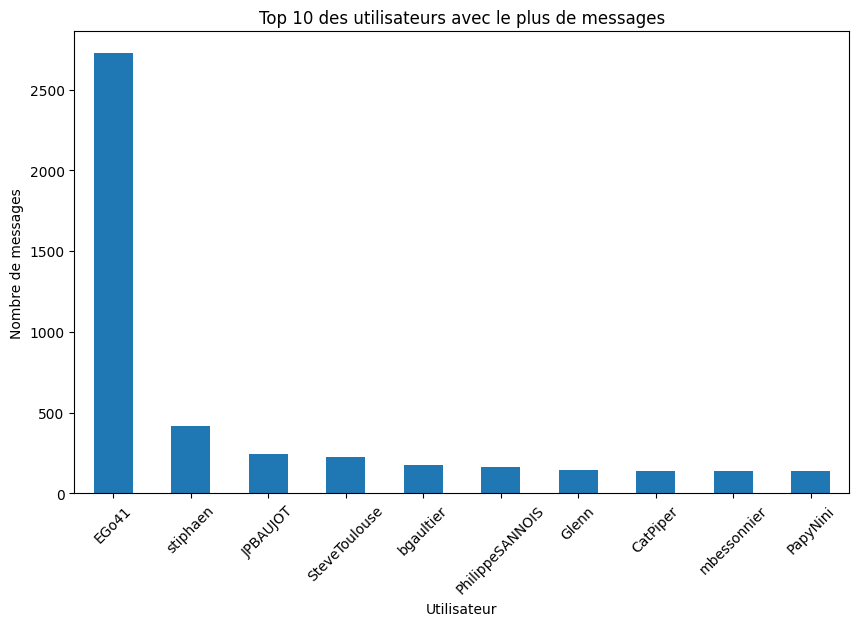

In [25]:
# Grouper par username et compter le nombre de messages, puis trier par ordre décroissant et prendre les 10 premiers
top_10_utilisateurs = df_IsEval['username'].value_counts().head(10)

# Créer le graphique
plt.figure(figsize=(10, 6))
top_10_utilisateurs.plot(kind='bar')
plt.title('Top 10 des utilisateurs avec le plus de messages')
plt.xlabel('Utilisateur')
plt.ylabel('Nombre de messages')
plt.xticks(rotation=45)
plt.show()

In [29]:
df_IsEval.columns
# Suppression des colonnes inutiles
df_IsEval_User = df_IsEval

df_IsEval_User.drop(['message_id', 'parent_id', 'thread_id', 'thread_type', 'title', 'context', 'courseware_title', 'type', 'created_at', 'updated_at', 'vote_down_count', 'vote_up_count', 'vote_point', 'vote_count', 'IsEval'], axis=1, inplace=True)


KeyError: "['message_id', 'parent_id', 'thread_id', 'thread_type', 'title', 'context', 'courseware_title', 'type', 'created_at', 'updated_at', 'vote_down_count', 'vote_up_count', 'vote_point', 'vote_count', 'IsEval'] not found in axis"

In [28]:
df_IsEval_User

# Filtrer les données où la valeur de la target n'est pas None
df_IsEval_User = df_IsEval_User[df_IsEval_User['grade'].notna()]

In [30]:
# Fonction pour extraire les informations
def extract_info(course_id):
    # Regex pour chaque format avec limite de 5 caractères pour le cours
    regex1 = r'^(.*?)/(.*?)(?:S.*?)?/(.*?)$'
    regex2 = r'^course-v1:(.*?)\+(.*?)(?:S.*?)?\+(.*?)$'

    # Vérifier et extraire les informations pour le premier format
    match1 = re.match(regex1, course_id)
    if match1:
        return match1.groups()

    # Vérifier et extraire les informations pour le deuxième format
    match2 = re.match(regex2, course_id)
    if match2:
        return match2.groups()

    # Retourner None si aucun format ne correspond
    return None, None, None

# Appliquer la fonction aux données
df_IsEval_User[['université', 'cours', 'session']] = df_IsEval_User['course_id'].apply(extract_info).apply(pd.Series)


In [31]:
df_IsEval_User

,course_id,username,body,id,city,country,gender,level_of_education,email,CSP,...,Certificate Type,Enrollment Track,date_grade_report,grade,Verification Status,date_problem_grade_report,Cohort Name,université,cours,session
20779,MinesTelecom/04017/session01,Djuz87,Bonjour à tous\nJe m'appelle Jean-Louis\n,58d572a36d4d80c00f9c3f5a,Limoges,FR,m,hs,djuz87@gmail.com,Employé,...,honor,honor,2016-05-30-1427,0.93,N/A,None,None,MinesTelecom,04017,session01
20780,MinesTelecom/04017/session01,Togo,"Bonjour,\nje m'appelle Thomas, j'habite Mens (...",58d572ad6d4d80c00f9c437c,Mens,FR,m,b,goujon.groshens@orange.fr,"Cadre, sup",...,honor,honor,2016-05-30-1427,0.98,N/A,None,None,MinesTelecom,04017,session01
20781,MinesTelecom/04017/session01,calvir,"Salut Thomas;\nPour la carte des participants,...",58d5728c6d4d80c00f9c358b,None,,m,hs,virgile.calvert@imbe.fr,Prof interm,...,honor,honor,2016-05-30-1427,1.0,N/A,None,None,MinesTelecom,04017,session01
20782,MinesTelecom/04017/session01,bgaultier,"Salut Thomas,\n\nJe confirme, il y a bien un F...",58d571846d4d80c00f9c244e,None,FR,m,m,b.gaultier@gmail.com,None,...,honor,honor,2016-05-30-1427,0.56,N/A,None,None,MinesTelecom,04017,session01
20783,MinesTelecom/04017/session01,KRYSS38,"Bonjour Thomas\nJe suis Christian, 62 ans et r...",58d572986d4d80c00f9c3ac1,None,,m,hs,None,Retraité,...,N/A,honor,2016-05-30-1427,0.4,N/A,None,None,MinesTelecom,04017,session01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149537,course-v1:MinesTelecom+04026+session03,lilsa,"Je suis Mamadou Saliou Diallo,étudiant sénégal...",5c604ac0e92e8f957032688f,None,None,None,None,None,None,...,None,None,None,None,None,None,None,MinesTelecom,04026,session03
151813,course-v1:MinesTelecom+04021+session05,Francois2m,"Bonjour, je m'appelle François et je suis inté...",5e17160edf5193c2cdb42d0b,None,None,None,None,None,None,...,None,None,None,None,None,None,None,MinesTelecom,04021,session05
151874,course-v1:MinesTelecom+04021+session05,gadic,Utilité principale : la réparation d'objets du...,58e399d5e8c4311b51510097,None,None,None,None,None,None,...,None,None,None,None,None,None,None,MinesTelecom,04021,session05
153018,MinesTelecom/04017S02/session02,valdiju,Je comprend mieux maintenant pourquoi le feu p...,58d571786d4d80c00f9c146b,Paris,FR,m,hs,None,Employé,...,N/A,honor,2017-03-29-2201,0.13,N/A,2017-03-11-1848,None,MinesTelecom,04017,session02


In [32]:
df_IsEval_User.drop(['course_id',"session" ],axis=1, inplace=True)

In [33]:
df_IsEval_User.columns

Index(['username', 'body', 'id', 'city', 'country', 'gender',
       'level_of_education', 'email', 'CSP', 'year_of_birth', 'csp', 'idUser',
       'Certificate Delivered', 'Certificate Eligible', 'Certificate Type',
       'Enrollment Track', 'date_grade_report', 'grade', 'Verification Status',
       'date_problem_grade_report', 'Cohort Name', 'université', 'cours'],
      dtype='object')

In [34]:
df_IsEval_User.drop(['id',"username"],axis=1, inplace=True)

In [35]:
df_certif_eligible  = df_IsEval_User[df_IsEval_User['Certificate Eligible'] == 'Y']
df_certif_delivered = df_IsEval_User[df_IsEval_User['Certificate Delivered'] == 'Y']

In [36]:
df_certif_eligible.sort_values(by='grade')

,body,city,country,gender,level_of_education,email,CSP,year_of_birth,csp,idUser,...,Certificate Eligible,Certificate Type,Enrollment Track,date_grade_report,grade,Verification Status,date_problem_grade_report,Cohort Name,université,cours
72629,j'ai répondu juste au quizz et l'idée est bien...,Grenoble,FR,m,m,None,None,1974,None,58d571bf6d4d80c00f9c313d,...,Y,N/A,honor,2017-04-12-2129mod,0.5,N/A,None,None,MinesTelecom,04018
74372,"Bonjour,\nJe ne parviens pas à boucler la 4ème...",Paris,FR,m,m,None,"Cadre, sup",1970,None,58d5717f6d4d80c00f9c1dc5,...,Y,N/A,honor,2017-04-12-2129mod,0.5,N/A,None,None,MinesTelecom,04018
109483,"Bonjour,\n\nJe traine sur la plateforme FUN de...",None,FR,m,m,philippe@meslin.eu,"Cadre, sup",1964,None,58d5729e6d4d80c00f9c3d73,...,Y,honor,honor,None,0.5,N/A,None,Default Group,MinesTelecom,04018
45394,"Merci cbernizet, moi non plus je ne trouvais p...",EVRUNES,FR,m,hs,None,Ouvrier,1981,None,58d571836d4d80c00f9c22ee,...,Y,N/A,honor,2016-12-12-0855,0.5,N/A,None,None,MinesTelecom,04021
45543,"Bonjour à tous,\nAprès avoir fait "" Menu ""Exte...",EVRUNES,FR,m,hs,None,Ouvrier,1981,None,58d571836d4d80c00f9c22ee,...,Y,N/A,honor,2016-12-12-0855,0.5,N/A,None,None,MinesTelecom,04021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22907,Le bouton pour atteindre le moniteur série (se...,Periana,ES,m,hs,chutetearer2013@gmail.com,Sans,1957,None,58d572b46d4d80c00f9c4610,...,Y,honor,honor,2016-05-30-1427,1.0,N/A,None,None,MinesTelecom,04017
54977,"Bonjour, \nJ'ai aussi acheté ce kit.\nComment ...",paris,FR,m,m,None,Sans,1976,None,58d571866d4d80c00f9c25d2,...,Y,honor,honor,2017-03-29-2201,1.0,N/A,2017-03-11-1848,None,MinesTelecom,04017
54976,"C'est celui que j'ai pris. Jusqu'au TP1, ça ma...",PARIS,FR,m,m,None,Enseignant,1978,None,58d5717d6d4d80c00f9c1acb,...,Y,honor,honor,2017-03-29-2201,1.0,N/A,2017-03-11-1848,None,MinesTelecom,04017
104629,Bonjour !\n\nIl me semble qu'il y a une contra...,None,None,f,None,None,Enseignant,None,None,58fef59188d1216b89e58669,...,Y,N/A,honor,None,1.0,N/A,None,Default Group,MinesTelecom,04021


In [37]:
df_certif_delivered.sort_values(by='grade')

,body,city,country,gender,level_of_education,email,CSP,year_of_birth,csp,idUser,...,Certificate Eligible,Certificate Type,Enrollment Track,date_grade_report,grade,Verification Status,date_problem_grade_report,Cohort Name,université,cours
76984,"Bonjour,\n\nMa question est simple. Les tests ...",None,None,None,None,None,None,None,None,592d87140d924cfc37f8e340,...,N,verified,verified,None,0.24,ID Verified,None,None,CNAM,01002
76389,"Bonjour, \n\nje me suis inscrite pour le certi...",None,None,None,None,None,None,None,None,592d87140d924cfc37f8e348,...,N,verified,verified,None,0.24,ID Verified,None,None,CNAM,01002
67955,"Salut EL44, j'ai loupé le test final (je n'ai ...",None,None,None,None,None,None,None,None,592d87140d924cfc37f8e340,...,N,verified,verified,None,0.24,ID Verified,None,None,CNAM,01002
57739,"Bonjour, \nJe m’appelle Cécile et je travaill...",None,None,None,None,None,None,None,None,58e267eee8c4311b5150f007,...,N,verified,verified,None,0.26,ID Verified,None,None,CNAM,01002
62917,Merci Flabaye pour ces commentaires. Je passe ...,None,None,None,None,None,None,None,None,58e267eee8c4311b5150f007,...,N,verified,verified,None,0.26,ID Verified,None,None,CNAM,01002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97192,Bonsoir\n\nSi on savait au moins quelle est la...,None,FR,m,m,None,"Cadre, sup",1953,None,58d5717d6d4d80c00f9c1b3c,...,Y,honor,honor,None,1.0,N/A,None,Default Group,MinesTelecom,04017
55611,"Bonjour, \n\nL'IDE est le logiciel qui permet ...",Metz,FR,m,other,None,Retraité,1945,None,58d571836d4d80c00f9c22b8,...,Y,honor,honor,2017-03-29-2201,1.0,N/A,2017-03-11-1848,None,MinesTelecom,04017
55574,"Bonjour, \n\nPour les débutants en code inform...",Lyon,FR,m,el,None,Retraité,1949,None,58d571846d4d80c00f9c2398,...,Y,honor,honor,2017-03-29-2201,1.0,N/A,2017-03-11-1848,None,MinesTelecom,04017
55663,"Bonsoir,\n\nVoici ce que j'ai dans mon program...",Metz,FR,m,other,None,Retraité,1945,None,58d571836d4d80c00f9c22b8,...,Y,honor,honor,2017-03-29-2201,1.0,N/A,2017-03-11-1848,None,MinesTelecom,04017


In [38]:
# Filtrer le DataFrame pour les utilisateurs qui sont éligibles et ont reçu un certificat
df_certif_eligible_and_delivered = df_IsEval_User[
    (df_IsEval_User['Certificate Eligible'] == 'Y') & 
    (df_IsEval_User['Certificate Delivered'] == 'Y')
]

In [39]:
df_certif_eligible_and_delivered.sort_values(by='grade')

,body,city,country,gender,level_of_education,email,CSP,year_of_birth,csp,idUser,...,Certificate Eligible,Certificate Type,Enrollment Track,date_grade_report,grade,Verification Status,date_problem_grade_report,Cohort Name,université,cours
109483,"Bonjour,\n\nJe traine sur la plateforme FUN de...",None,FR,m,m,philippe@meslin.eu,"Cadre, sup",1964,None,58d5729e6d4d80c00f9c3d73,...,Y,honor,honor,None,0.5,N/A,None,Default Group,MinesTelecom,04018
27010,Je ferai attention à ne pas faire de pont mais...,EYGUIERES,FR,m,m,olivier.morganti@gmail.com,None,1976,None,58d5728d6d4d80c00f9c3631,...,Y,honor,honor,2016-07-20-1511,0.5,N/A,None,None,MinesTelecom,04018
29547,Dans les préférences de l'IDE tu peux demander...,reims,FR,m,hs,xavier.nayrac@gmail.com,"Cadre, sup",1972,None,58d574016d4d80c00f9c5dbd,...,Y,honor,honor,2016-07-20-1511,0.5,N/A,None,None,MinesTelecom,04018
21632,"Bonjour,\n\nDans la partie de test d'évaluatio...",Orléans,FR,m,p,None,None,1984,None,58d5728e6d4d80c00f9c3678,...,Y,honor,honor,2016-05-30-1427,0.51,N/A,None,None,MinesTelecom,04017
20861,sami.ezzerouali@etu.enseeiht.fr,TOULOUSE,FR,m,other,sami.ezzerouali@hotmail.com,None,1995,None,58d5729c6d4d80c00f9c3c8e,...,Y,honor,honor,2016-05-30-1427,0.51,N/A,None,None,MinesTelecom,04017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25212,"Bonjour,\nAvec le script Sweep lorsque je boug...",Limours,FR,,m,chugonet.pro@gmail.com,"Cadre, sup",None,None,58d572dc6d4d80c00f9c5254,...,Y,honor,honor,2016-07-20-1511,1.0,N/A,None,None,MinesTelecom,04018
25205,"Bonsoir,\n\n> Erreur d'ouverture du port série...",Auxonne,FR,m,none,o.cretey@cia-informatique.com,Prof interm,1958,None,58d572966d4d80c00f9c3a24,...,Y,honor,honor,2016-07-20-1511,1.0,N/A,None,None,MinesTelecom,04018
25203,"Bonjour,\n\nJ'ai soumis et verrouillé une vers...",Echirolles,FR,m,m,luc@luc-laurens.com,"Cadre, sup",1965,None,58d572a96d4d80c00f9c4188,...,Y,honor,honor,2016-07-20-1511,1.0,N/A,None,None,MinesTelecom,04018
63461,@PhB J'ai le même problème. Je suppose que c'e...,Liège,BE,m,jhs,None,Sans,1963,None,58d571876d4d80c00f9c275d,...,Y,honor,honor,2017-03-29-2201,1.0,N/A,2017-03-11-1848,None,MinesTelecom,04017


In [40]:
nombre_cours1 = df_certif_eligible['cours'].nunique()
print(nombre_cours1)
nombre_cours2 = df_certif_delivered['cours'].nunique()
print(nombre_cours2)
nombre_cours3 = df_certif_eligible_and_delivered['cours'].nunique()
print(nombre_cours3)

5
5
5


In [41]:
df_cnam_delivered = df_certif_delivered[df_certif_delivered['université'] == 'CNAM']
df_cnam_eligible  = df_certif_eligible[df_certif_eligible['université'] == 'CNAM']
df_cnam = df_IsEval_User[df_IsEval_User['université'] == 'CNAM']

In [42]:
df_cnam_eligible.sort_values(by='grade').nunique()

body                         1127
city                           16
country                         7
gender                          3
level_of_education              6
email                           4
CSP                             3
year_of_birth                  14
csp                             0
idUser                        345
Certificate Delivered           1
Certificate Eligible            1
Certificate Type                2
Enrollment Track                2
date_grade_report               0
grade                          43
Verification Status             3
date_problem_grade_report       0
Cohort Name                     0
université                      1
cours                           1
dtype: int64

In [43]:
df_cnam_delivered.sort_values(by='grade').nunique()

body                         1133
city                           16
country                         7
gender                          3
level_of_education              6
email                           4
CSP                             3
year_of_birth                  14
csp                             0
idUser                        348
Certificate Delivered           1
Certificate Eligible            2
Certificate Type                2
Enrollment Track                2
date_grade_report               0
grade                          45
Verification Status             3
date_problem_grade_report       0
Cohort Name                     0
université                      1
cours                           1
dtype: int64

In [44]:
df_IsEval_grade = df_IsEval_User.drop(["idUser","Certificate Eligible","Verification Status","Cohort Name","idUser"],axis=1, inplace=True)

In [45]:
# Ajouter la colonne isEmail
df_IsEval_User['isEmail'] = df_IsEval_User['email'].notna() & (df_IsEval_User['email'] != '')

In [90]:
columns_of_interest = ['city', 'country', 'gender', 'level_of_education', 'email', 'CSP', 'year_of_birth']
# Remplacer 'None', 'none', et '' par np.nan
df_IsEval_User[columns_of_interest] = df_IsEval_User[columns_of_interest].replace(['None', 'none', '',None], np.nan)
df_IsEval_User['datagiven'] = df_IsEval_User[columns_of_interest].notna().sum(axis=1)

In [91]:
df_IsEval_User

,body,city,country,gender,level_of_education,email,CSP,year_of_birth,Certificate Delivered,date_grade_report,grade,date_problem_grade_report,université,cours,isEmail,datagiven
20779,Bonjour à tous\nJe m'appelle Jean-Louis\n,Limoges,FR,m,hs,djuz87@gmail.com,Employé,1968.0,Y,2016-05-30-1427,0.93,None,MinesTelecom,04017,True,7
20780,"Bonjour,\nje m'appelle Thomas, j'habite Mens (...",Mens,FR,m,b,goujon.groshens@orange.fr,"Cadre, sup",1963.0,Y,2016-05-30-1427,0.98,None,MinesTelecom,04017,True,7
20781,"Salut Thomas;\nPour la carte des participants,...",NaN,NaN,m,hs,virgile.calvert@imbe.fr,Prof interm,1976.0,Y,2016-05-30-1427,1.0,None,MinesTelecom,04017,True,5
20782,"Salut Thomas,\n\nJe confirme, il y a bien un F...",NaN,FR,m,m,b.gaultier@gmail.com,NaN,1986.0,Y,2016-05-30-1427,0.56,None,MinesTelecom,04017,True,5
20783,"Bonjour Thomas\nJe suis Christian, 62 ans et r...",NaN,NaN,m,hs,NaN,Retraité,1954.0,N,2016-05-30-1427,0.4,None,MinesTelecom,04017,False,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149537,"Je suis Mamadou Saliou Diallo,étudiant sénégal...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,MinesTelecom,04026,False,0
151813,"Bonjour, je m'appelle François et je suis inté...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,MinesTelecom,04021,False,0
151874,Utilité principale : la réparation d'objets du...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,MinesTelecom,04021,False,0
153018,Je comprend mieux maintenant pourquoi le feu p...,Paris,FR,m,hs,NaN,Employé,1987.0,N,2017-03-29-2201,0.13,2017-03-11-1848,MinesTelecom,04017,False,6


In [92]:
df_IsEval_User.drop(["csp","Certificate Type","Enrollment Track"],axis=1, inplace=True)

KeyError: "['csp', 'Certificate Type', 'Enrollment Track'] not found in axis"

In [93]:
df_IsEval_User
df_IsEval_User_v2 = df_IsEval_User.drop(df_cnam.index)

In [94]:
duplicated_emails = df_IsEval_User_v2[df_IsEval_User_v2.duplicated(subset=['email','cours'], keep=False)]
email_not_none = duplicated_emails[duplicated_emails['email'].notna()]
date_none = email_not_none[email_not_none['date_grade_report'].isna()]

In [95]:
date_none

,body,city,country,gender,level_of_education,email,CSP,year_of_birth,Certificate Delivered,date_grade_report,grade,date_problem_grade_report,université,cours,isEmail,datagiven
21353,Merci Emmanuel pour cette réponse rapide ; le...,NaN,NaN,m,m,Domrx@wanadoo.fr,Retraité,1952.0,None,None,None,None,MinesTelecom,04017,True,5
21355,Merci Philippe !,NaN,NaN,m,m,Domrx@wanadoo.fr,Retraité,1952.0,None,None,None,None,MinesTelecom,04017,True,5
21352,"Merci Messieurs, mais aucun résultat !\n",NaN,NaN,m,m,Domrx@wanadoo.fr,Retraité,1952.0,None,None,None,None,MinesTelecom,04017,True,5
21349,Bonjour !\nQuand même bien long pour installer...,NaN,NaN,m,m,Domrx@wanadoo.fr,Retraité,1952.0,None,None,None,None,MinesTelecom,04017,True,5
21347,"Bonjour\n\nAprès de nombreux essais , il m'est...",NaN,NaN,m,m,Domrx@wanadoo.fr,Retraité,1952.0,None,None,None,None,MinesTelecom,04017,True,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145114,"Bonjour, \nCela devrais être possible ? \nEm...",NaN,NaN,m,m,emmanuel.goudot@gmail.com,"Cadre, sup",1966.0,N,None,0.0,None,MinesTelecom,04021,True,5
145138,"Bonjour, \nPas mal du tout ! Vous avez partag...",NaN,NaN,m,m,emmanuel.goudot@gmail.com,"Cadre, sup",1966.0,N,None,0.0,None,MinesTelecom,04021,True,5
145175,"Bonjour, \nC'est une suggestion, pourquoi pas...",NaN,NaN,m,m,emmanuel.goudot@gmail.com,"Cadre, sup",1966.0,N,None,0.0,None,MinesTelecom,04021,True,5
147685,"Hello, \nIl y a pas mal de réponses dans le c...",NaN,NaN,m,m,emmanuel.goudot@gmail.com,"Cadre, sup",1966.0,N,None,0.07,None,MinesTelecom,04026,True,5


In [96]:
# Supprimer les lignes de df_IsEval_User présentes dans date_none
df_IsEval_User_cleaned_final = df_IsEval_User_v2.drop(date_none.index)

In [97]:
df_IsEval_User_cleaned_final

,body,city,country,gender,level_of_education,email,CSP,year_of_birth,Certificate Delivered,date_grade_report,grade,date_problem_grade_report,université,cours,isEmail,datagiven
20779,Bonjour à tous\nJe m'appelle Jean-Louis\n,Limoges,FR,m,hs,djuz87@gmail.com,Employé,1968.0,Y,2016-05-30-1427,0.93,None,MinesTelecom,04017,True,7
20780,"Bonjour,\nje m'appelle Thomas, j'habite Mens (...",Mens,FR,m,b,goujon.groshens@orange.fr,"Cadre, sup",1963.0,Y,2016-05-30-1427,0.98,None,MinesTelecom,04017,True,7
20781,"Salut Thomas;\nPour la carte des participants,...",NaN,NaN,m,hs,virgile.calvert@imbe.fr,Prof interm,1976.0,Y,2016-05-30-1427,1.0,None,MinesTelecom,04017,True,5
20782,"Salut Thomas,\n\nJe confirme, il y a bien un F...",NaN,FR,m,m,b.gaultier@gmail.com,NaN,1986.0,Y,2016-05-30-1427,0.56,None,MinesTelecom,04017,True,5
20783,"Bonjour Thomas\nJe suis Christian, 62 ans et r...",NaN,NaN,m,hs,NaN,Retraité,1954.0,N,2016-05-30-1427,0.4,None,MinesTelecom,04017,False,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149537,"Je suis Mamadou Saliou Diallo,étudiant sénégal...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,MinesTelecom,04026,False,0
151813,"Bonjour, je m'appelle François et je suis inté...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,MinesTelecom,04021,False,0
151874,Utilité principale : la réparation d'objets du...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,MinesTelecom,04021,False,0
153018,Je comprend mieux maintenant pourquoi le feu p...,Paris,FR,m,hs,NaN,Employé,1987.0,N,2017-03-29-2201,0.13,2017-03-11-1848,MinesTelecom,04017,False,6


In [98]:
df_final_test = df_IsEval_User_cleaned_final.drop(columns=['email','date_grade_report','date_grade_report','date_problem_grade_report','université'],axis = 1)

In [99]:
df_final_test

,body,city,country,gender,level_of_education,CSP,year_of_birth,Certificate Delivered,grade,cours,isEmail,datagiven
20779,Bonjour à tous\nJe m'appelle Jean-Louis\n,Limoges,FR,m,hs,Employé,1968.0,Y,0.93,04017,True,7
20780,"Bonjour,\nje m'appelle Thomas, j'habite Mens (...",Mens,FR,m,b,"Cadre, sup",1963.0,Y,0.98,04017,True,7
20781,"Salut Thomas;\nPour la carte des participants,...",NaN,NaN,m,hs,Prof interm,1976.0,Y,1.0,04017,True,5
20782,"Salut Thomas,\n\nJe confirme, il y a bien un F...",NaN,FR,m,m,NaN,1986.0,Y,0.56,04017,True,5
20783,"Bonjour Thomas\nJe suis Christian, 62 ans et r...",NaN,NaN,m,hs,Retraité,1954.0,N,0.4,04017,False,4
...,...,...,...,...,...,...,...,...,...,...,...,...
149537,"Je suis Mamadou Saliou Diallo,étudiant sénégal...",NaN,NaN,NaN,NaN,NaN,NaN,None,None,04026,False,0
151813,"Bonjour, je m'appelle François et je suis inté...",NaN,NaN,NaN,NaN,NaN,NaN,None,None,04021,False,0
151874,Utilité principale : la réparation d'objets du...,NaN,NaN,NaN,NaN,NaN,NaN,None,None,04021,False,0
153018,Je comprend mieux maintenant pourquoi le feu p...,Paris,FR,m,hs,Employé,1987.0,N,0.13,04017,False,6


In [100]:
# Obtenir les valeurs uniques de la colonne 'colonne'
csp = df_final_test['CSP'].unique()
educ = df_final_test['level_of_education'].unique()

In [101]:
df_fulldata = df_final_test[df_final_test['datagiven'] == 7]

In [124]:
df_fullfiltered = df_fulldata[df_fulldata['Certificate Delivered'].isin(['N/A']) | df_fulldata['Certificate Delivered'].isna()]

In [125]:
df_fullfiltered

,body,city,country,gender,level_of_education,CSP,year_of_birth,Certificate Delivered,grade,cours,isEmail,datagiven
21085,tout à fait d accord egalement\n,PARIS,FR,m,m,"Cadre, sup",1973.0,None,None,04017,True,7
101240,j ai posté le mauvais liens comment donner la...,lomme,FR,m,other,Employé,1968.0,N/A,0.94,04021,True,7
140672,"Bonjour à tous,\n\nBenjamin, 37 ans dans le Pa...",Noyelles les Vermelles,FR,m,hs,Employé,1981.0,N/A,0.13,04026,True,7
141000,"Bonjour, \nJuste un petit feedback.\n\nJ'ai so...",Montpellier,FR,m,m,Enseignant,1985.0,N/A,0.66,04026,True,7


In [126]:
# Supprimer les lignes de df_IsEval_User présentes dans date_none
df_full_final = df_fulldata.drop(df_fullfiltered.index)

In [143]:
# Compter le nombre total par valeur unique dans la colonne 'Certificate Delivered'
certif_counts = df_full_final['Certificate Delivered'].value_counts(dropna=False)

print(certif_counts)

Nombre total par valeur unique dans la colonne 'Certificate Delivered':
Certificate Delivered
Y    1556
N     416
Name: count, dtype: int64


In [157]:
df_certificate_N = df_full_final.loc[(df_full_final['Certificate Delivered'] == 'N') & (df_full_final['grade'] > 0.5)]

In [158]:
df_certificate_N

,body,city,country,gender,level_of_education,CSP,year_of_birth,Certificate Delivered,grade,cours,isEmail,datagiven
44550,<b>Bonjour à tous</b><br><br>\nJe suis ingénie...,cachan,fr,m,m,"cadre, sup",1970.0,N,0.97,04021,True,7
44564,Après avoir bricolé seule avec Raspberry Ardui...,béthune,fr,f,p,enseignant,1973.0,N,0.92,04021,True,7
44567,"Bonjour,\nQuand je clique sur le bouton associ...",maisons alfort,fr,m,m,retraité,1951.0,N,0.97,04021,True,7
44573,"Mince, je viens de le faire pinocchio :D\n",perpignan,fr,m,hs,"cadre, sup",1974.0,N,0.97,04021,True,7
44591,Bonsoir\nJe suis très intéressée par ton expér...,béthune,fr,f,p,enseignant,1973.0,N,0.92,04021,True,7
...,...,...,...,...,...,...,...,...,...,...,...,...
76460,"Bonjour, je voulais savoir si j'étais la seule...",montataire,fr,f,m,recherche emploi,1971.0,N,0.67,04018,True,7
76462,Merci pour tes encouragements... Je suis surto...,montataire,fr,f,m,recherche emploi,1971.0,N,0.67,04018,True,7
91586,je suis Souleymane Kone et je viens de commenc...,abidjan,ci,m,jhs,etudiant,1986.0,N,0.53,04017,True,7
93160,Je n'arrive pas à formater ma carte Arduino et...,paris,fr,f,jhs,ouvrier,1951.0,N,0.55,04017,True,7


In [179]:
df_full_final_classifier = df_full_final.drop(df_certificate_N.index)

In [180]:
df_full_final_classifier

,body,city,country,gender,level_of_education,CSP,year_of_birth,Certificate Delivered,grade,cours,isEmail,datagiven
20779,Bonjour à tous\nJe m'appelle Jean-Louis\n,limoges,fr,m,hs,employé,1968.0,Y,0.93,04017,True,7
20780,"Bonjour,\nje m'appelle Thomas, j'habite Mens (...",mens,fr,m,b,"cadre, sup",1963.0,Y,0.98,04017,True,7
20788,"Bonjour,\nJe suis Wassim IBRAHIM étudiant en 2...",sousse,tn,m,other,etudiant,1993.0,Y,0.91,04017,True,7
20789,"Bonjour à tous,\nje commence le Mooc sur Ardui...",lyon,fr,m,m,retraité,1956.0,Y,0.98,04017,True,7
20793,"Bonjour, \nJe m'appelle lélio, ingénieur en in...",saint mandé,fr,m,b,employé,1986.0,Y,1.00,04017,True,7
...,...,...,...,...,...,...,...,...,...,...,...,...
130212,"Bonjour,\nC'est quoi ton probl�me ? je suis su...",saint-maixent l'ecole,fr,m,m,"cadre, sup",1958.0,Y,0.81,04021,True,7
132246,"Bonjour � tous,\nJe compte apprendre avec la c...",bamako,ml,m,hs,"artisan, commerçant ou chef d'entreprise",1979.0,N,0.41,04021,True,7
137527,"Bonjour, Je ne comprends pas le premier schéma...",drancy,fr,m,other,"cadre, sup",1956.0,Y,1.00,04017,True,7
143466,"Bonjour,\n\nSi ce n'est pas Slic3r alors c'est...",lome,tg,m,a,employé,1983.0,N,0.00,04021,True,7


In [181]:
df_full_final_classifier_multiplier = df_full_final_classifier.loc[df_full_final_classifier['Certificate Delivered'] == 'N']
df_full_final_classifier = pd.concat([df_full_final_classifier] + [df_full_final_classifier_multiplier] * 5, ignore_index=True)

In [182]:
df_full_final_classifier

,body,city,country,gender,level_of_education,CSP,year_of_birth,Certificate Delivered,grade,cours,isEmail,datagiven
0,Bonjour à tous\nJe m'appelle Jean-Louis\n,limoges,fr,m,hs,employé,1968.0,Y,0.93,04017,True,7
1,"Bonjour,\nje m'appelle Thomas, j'habite Mens (...",mens,fr,m,b,"cadre, sup",1963.0,Y,0.98,04017,True,7
2,"Bonjour,\nJe suis Wassim IBRAHIM étudiant en 2...",sousse,tn,m,other,etudiant,1993.0,Y,0.91,04017,True,7
3,"Bonjour à tous,\nje commence le Mooc sur Ardui...",lyon,fr,m,m,retraité,1956.0,Y,0.98,04017,True,7
4,"Bonjour, \nJe m'appelle lélio, ingénieur en in...",saint mandé,fr,m,b,employé,1986.0,Y,1.00,04017,True,7
...,...,...,...,...,...,...,...,...,...,...,...,...
3003,Bonjour\n\nAprès des études d'électronique il ...,l'hay les roses,fr,m,hs,recherche emploi,1961.0,N,0.00,04018,True,7
3004,"Bonjour, \n\nVotre copie a bien été reçue, ave...",paris,fr,f,m,"cadre, sup",1989.0,N,0.00,04018,True,7
3005,"Bonjour � tous,\nJe compte apprendre avec la c...",bamako,ml,m,hs,"artisan, commerçant ou chef d'entreprise",1979.0,N,0.41,04021,True,7
3006,"Bonjour,\n\nSi ce n'est pas Slic3r alors c'est...",lome,tg,m,a,employé,1983.0,N,0.00,04021,True,7


In [183]:
# Compter le nombre total par valeur unique dans la colonne 'Certificate Delivered'
certif_counts = df_full_final_classifier['Certificate Delivered'].value_counts(dropna=False)

print(certif_counts)

Certificate Delivered
Y    1556
N    1452
Name: count, dtype: int64


In [194]:
# Compter le nombre de notes en dessous de 0.5

# Convertir la colonne 'grade' en type numérique (float)
df_full_final['grade'] = pd.to_numeric(df_full_final['grade'], errors='coerce')

count_below_0_5 = df_full_final['grade'][df_full_final['grade'] < 0.5].count()
count_above_0_5 = df_full_final['grade'][df_full_final['grade'] > 0.5].count()
count0_5 = df_full_final['grade'][df_full_final['grade'] ==  0.5].count()


print(count_below_0_5)
print(count_above_0_5)
print(count0_5)

240
1729
3


In [200]:
df_full_final_regressor = df_full_final
df_full_final_regressor_multiplier = df_full_final[df_full_final['grade'] < 0.5]
df_full_final_regressor = pd.concat([df_full_final] + [df_full_final_regressor_multiplier] * 6, ignore_index=True)

In [201]:
df_full_final_regressor

,body,city,country,gender,level_of_education,CSP,year_of_birth,Certificate Delivered,grade,cours,isEmail,datagiven
0,Bonjour à tous\nJe m'appelle Jean-Louis\n,limoges,fr,m,hs,employé,1968.0,Y,0.93,04017,True,7
1,"Bonjour,\nje m'appelle Thomas, j'habite Mens (...",mens,fr,m,b,"cadre, sup",1963.0,Y,0.98,04017,True,7
2,"Bonjour,\nJe suis Wassim IBRAHIM étudiant en 2...",sousse,tn,m,other,etudiant,1993.0,Y,0.91,04017,True,7
3,"Bonjour à tous,\nje commence le Mooc sur Ardui...",lyon,fr,m,m,retraité,1956.0,Y,0.98,04017,True,7
4,"Bonjour, \nJe m'appelle lélio, ingénieur en in...",saint mandé,fr,m,b,employé,1986.0,Y,1.00,04017,True,7
...,...,...,...,...,...,...,...,...,...,...,...,...
3407,Bonjour\n\nAprès des études d'électronique il ...,l'hay les roses,fr,m,hs,recherche emploi,1961.0,N,0.00,04018,True,7
3408,"Bonjour, \n\nVotre copie a bien été reçue, ave...",paris,fr,f,m,"cadre, sup",1989.0,N,0.00,04018,True,7
3409,"Bonjour � tous,\nJe compte apprendre avec la c...",bamako,ml,m,hs,"artisan, commerçant ou chef d'entreprise",1979.0,N,0.41,04021,True,7
3410,"Bonjour,\n\nSi ce n'est pas Slic3r alors c'est...",lome,tg,m,a,employé,1983.0,N,0.00,04021,True,7


In [202]:
# Compter le nombre de notes en dessous de 0.5

# Convertir la colonne 'grade' en type numérique (float)
df_full_final['grade'] = pd.to_numeric(df_full_final['grade'], errors='coerce')

count_below_0_5 = df_full_final_regressor['grade'][df_full_final_regressor['grade'] < 0.5].count()
count_above_0_5 = df_full_final_regressor['grade'][df_full_final_regressor['grade'] > 0.5].count()
count0_5 = df_full_final_regressor['grade'][df_full_final_regressor['grade'] ==  0.5].count()


print(count_below_0_5)
print(count_above_0_5)
print(count0_5)

1680
1729
3


In [203]:
# Colonnes d'intérêt
string_column = ['city', 'country', 'gender', 'level_of_education', 'CSP']
# Fonction pour convertir en minuscules et supprimer les backslashes
def transform_string(s):
    if isinstance(s, str):
        return s.lower().replace('\\', '')
    return s

# Appliquer la transformation sur chaque colonne de type string
for col in string_column:
    df_full_final[col] = df_full_final[col].apply(transform_string)
    df_full_final_classifier[col] = df_full_final_classifier[col].apply(transform_string)
    df_full_final_regressor[col] = df_full_final_regressor[col].apply(transform_string)

In [213]:
csp = df_full_final['CSP'].unique()
csp_classifier = df_full_final_classifier['CSP'].unique()
csp_regressor = df_full_final_regressor['CSP'].unique()



educ = df_full_final['level_of_education'].unique()
educ_classifier = df_full_final_classifier['level_of_education'].unique()
educ_regressor = df_full_final_regressor['level_of_education'].unique()

In [210]:
csp_classifier

array(['employé', 'cadre, sup', 'etudiant', 'retraité', 'enseignant',
       'sans', "artisan, commerçant ou chef d'entreprise", 'prof interm',
       'ouvrier', 'recherche emploi'], dtype=object)

In [211]:
csp_regressor

array(['employé', 'cadre, sup', 'etudiant', 'retraité', 'enseignant',
       'sans', "artisan, commerçant ou chef d'entreprise", 'prof interm',
       'ouvrier', 'recherche emploi'], dtype=object)

In [205]:
csp

array(['employé', 'cadre, sup', 'etudiant', 'retraité', 'enseignant',
       'sans', "artisan, commerçant ou chef d'entreprise", 'prof interm',
       'ouvrier', 'recherche emploi'], dtype=object)

In [215]:
educ

array(['hs', 'b', 'other', 'm', 'p', 'jhs', 'el', 'a'], dtype=object)

In [214]:
educ_classifier

array(['hs', 'b', 'other', 'm', 'p', 'jhs', 'el', 'a'], dtype=object)

In [216]:
educ_regressor

array(['hs', 'b', 'other', 'm', 'p', 'jhs', 'el', 'a'], dtype=object)

In [131]:
# Afficher toutes les lignes et colonnes
#pd.set_option('display.max_rows', None)  # Afficher toutes les lignes
#pd.set_option('display.max_columns', None)  # Afficher toutes les colonnes
#pd.set_option('display.max_colwidth', None)  # Afficher toute la largeur de la colonne
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.max_colwidth')

df_full_final

,body,city,country,gender,level_of_education,CSP,year_of_birth,Certificate Delivered,grade,cours,isEmail,datagiven
20779,Bonjour à tous\nJe m'appelle Jean-Louis\n,limoges,fr,m,hs,employé,1968.0,Y,0.93,04017,True,7
20780,"Bonjour,\nje m'appelle Thomas, j'habite Mens (...",mens,fr,m,b,"cadre, sup",1963.0,Y,0.98,04017,True,7
20788,"Bonjour,\nJe suis Wassim IBRAHIM étudiant en 2...",sousse,tn,m,other,etudiant,1993.0,Y,0.91,04017,True,7
20789,"Bonjour à tous,\nje commence le Mooc sur Ardui...",lyon,fr,m,m,retraité,1956.0,Y,0.98,04017,True,7
20793,"Bonjour, \nJe m'appelle lélio, ingénieur en in...",saint mandé,fr,m,b,employé,1986.0,Y,1.0,04017,True,7
...,...,...,...,...,...,...,...,...,...,...,...,...
130212,"Bonjour,\nC'est quoi ton probl�me ? je suis su...",saint-maixent l'ecole,fr,m,m,"cadre, sup",1958.0,Y,0.81,04021,True,7
132246,"Bonjour � tous,\nJe compte apprendre avec la c...",bamako,ml,m,hs,"artisan, commerçant ou chef d'entreprise",1979.0,N,0.41,04021,True,7
137527,"Bonjour, Je ne comprends pas le premier schéma...",drancy,fr,m,other,"cadre, sup",1956.0,Y,1.0,04017,True,7
143466,"Bonjour,\n\nSi ce n'est pas Slic3r alors c'est...",lome,tg,m,a,employé,1983.0,N,0.0,04021,True,7


In [132]:
# Vérifier la présence de NaN
has_nan = df_full_final.isnull().values.any()
print(f"Le DataFrame contient des valeurs NaN : {has_nan}")

Le DataFrame contient des valeurs NaN : False


In [133]:
# Compter les NaN dans chaque colonne
nan_counts = df_full_final.isnull().sum()
print("Nombre de valeurs NaN dans chaque colonne :")
print(nan_counts)

Nombre de valeurs NaN dans chaque colonne :
body                     0
city                     0
country                  0
gender                   0
level_of_education       0
CSP                      0
year_of_birth            0
Certificate Delivered    0
grade                    0
cours                    0
isEmail                  0
datagiven                0
dtype: int64


In [134]:
# Afficher les lignes contenant des NaN
rows_with_nan = df_full_final[df_full_final.isnull().any(axis=1)]
print("Lignes contenant des valeurs NaN :")
print(rows_with_nan)

Lignes contenant des valeurs NaN :
Empty DataFrame
Columns: [body, city, country, gender, level_of_education, CSP, year_of_birth, Certificate Delivered, grade, cours, isEmail, datagiven]
Index: []


In [217]:
# Créer une copie de l'ensemble de données
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import GridSearchCV
df_regressor = df_full_final_regressor.copy()

# Identifier les colonnes catégorielles et numériques
categorical_columns_regressor = ['level_of_education', 'CSP', 'country', 'gender', 'city']
numeric_columns_regressor = ['year_of_birth', 'cours']

# Encoder les colonnes catégorielles avec LabelEncoder
label_encoders_regressor = {}
for column in categorical_columns_regressor:
    encoder = LabelEncoder()
    df_regressor[column] = encoder.fit_transform(df_regressor[column])
    label_encoders_regressor[column] = encoder

# Sélectionner les caractéristiques et la cible
X_regressor = df_regressor.drop(columns=['grade', 'isEmail', 'body', 'Certificate Delivered','datagiven'])
y_regressor = df_regressor['grade']

# Appliquer le MinMaxScaler sur les colonnes numériques
scaler_regressor = MinMaxScaler()
X_regressor[numeric_columns_regressor] = scaler_regressor.fit_transform(X_regressor[numeric_columns_regressor])

# Division des données en ensembles de formation et de test
X_train_regressor, X_test_regressor, y_train_regressor, y_test_regressor = train_test_split(X_regressor, y_regressor, test_size=0.2, random_state=42)

# Définir les paramètres à tester
param_grid_regressor = {
    'n_estimators': [100, 200, 300,500],
    'max_depth': [10, 20, 30,50,100, None],
    'min_samples_split': [2,3,4, 5, 10],
    'min_samples_leaf': [1],
    'max_features': ['sqrt']
}

# Initialiser le modèle
model_regressor = RandomForestRegressor(random_state=42)

# Effectuer une recherche en grille
grid_search_regressor = GridSearchCV(estimator=model_regressor, param_grid=param_grid_regressor, cv=5, n_jobs=-1, verbose=2, scoring='r2')
grid_search_regressor.fit(X_train_regressor, y_train_regressor)

# Meilleurs paramètres
best_params_regressor = grid_search_regressor.best_params_
print("Meilleurs paramètres trouvés :", best_params_regressor)

# Entraîner le modèle avec les meilleurs paramètres
best_model_regressor = grid_search_regressor.best_estimator_
best_model_regressor.fit(X_train_regressor, y_train_regressor)

# Prédiction sur les données de test
y_pred_best_regressor = best_model_regressor.predict(X_test_regressor)

# Évaluation
mae_best_regressor = mean_absolute_error(y_test_regressor, y_pred_best_regressor)
mse_best_regressor = mean_squared_error(y_test_regressor, y_pred_best_regressor)
r2_best_regressor = r2_score(y_test_regressor, y_pred_best_regressor)
rmse_best_regressor = mse_best_regressor ** 0.5

print(f"MAE: {mae_best_regressor}")
print(f"MSE: {mse_best_regressor}")
print(f"RMSE: {rmse_best_regressor}")
print(f"R^2: {r2_best_regressor}")

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Meilleurs paramètres trouvés : {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
MAE: 0.033361669795564736
MSE: 0.007024434486765603
RMSE: 0.08381189943418299
R^2: 0.9497793826240485


In [218]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score
import pandas as pd

# Copier le DataFrame
df_classifier = df_full_final_classifier.copy()

# Identifier les colonnes catégorielles et numériques
categorical_columns_classifier = ['level_of_education', 'CSP', 'country', 'gender', 'city']

# Encoder les colonnes catégorielles avec LabelEncoder
label_encoders_classifier = {}
for column in categorical_columns_classifier:
    encoder = LabelEncoder()
    df_classifier[column] = encoder.fit_transform(df_classifier[column])
    label_encoders_classifier[column] = encoder

# Sélectionner les caractéristiques et la cible
X_classifier = df_classifier.drop(columns=['grade', 'isEmail', 'body', 'Certificate Delivered','datagiven','year_of_birth','cours'])
y_classifier = df_classifier['Certificate Delivered']


# Vérification des colonnes dans X
print("Colonnes dans X après encodage, sélection et mise à l'échelle : ", X_classifier.columns)

# Division des données en ensembles de formation et de test
X_train_classifier, X_test_classifier, y_train_classifier, y_test_classifier = train_test_split(X_classifier, y_classifier, test_size=0.2, random_state=42)

# Définir les paramètres à tester
param_grid = {
    'n_estimators': [100, 200, 300,500],
    'max_depth': [10, 20, 30,50,100, None],
    'min_samples_split': [2,3,4, 5, 10],
    'min_samples_leaf': [1],
    'max_features': ['sqrt']
}

# Initialiser le modèle RandomForestClassifier
model_classifier = RandomForestClassifier(random_state=42)

# Effectuer une recherche en grille
grid_search_classifier = GridSearchCV(estimator=model_classifier, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search_classifier.fit(X_train_classifier, y_train_classifier)

# Meilleurs paramètres
best_params_classifier = grid_search_classifier.best_params_
print("Meilleurs paramètres trouvés :", best_params_classifier)

# Entraîner le modèle avec les meilleurs paramètres
best_model_classifier = grid_search_classifier.best_estimator_
best_model_classifier.fit(X_train_classifier, y_train_classifier)

# Prédiction sur les données de test
y_pred_best_classifier = best_model_classifier.predict(X_test_classifier)

# Calcul de la précision
accuracy = accuracy_score(y_test_classifier, y_pred_best_classifier)
print(f"Précision : {accuracy}")


Colonnes dans X après encodage, sélection et mise à l'échelle :  Index(['city', 'country', 'gender', 'level_of_education', 'CSP'], dtype='object')
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Meilleurs paramètres trouvés : {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}
Précision : 0.9169435215946844


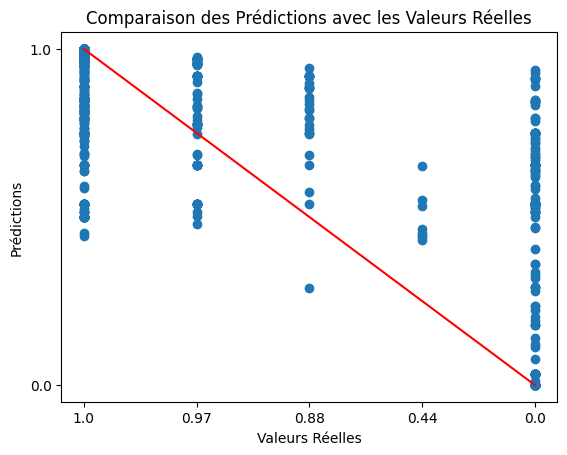

In [61]:
# Comparaison des prédictions avec les valeurs réelles
plt.scatter(y_test, y_pred_best)
plt.xlabel('Valeurs Réelles')
plt.ylabel('Prédictions')
plt.title('Comparaison des Prédictions avec les Valeurs Réelles')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Ligne y=x
plt.show()

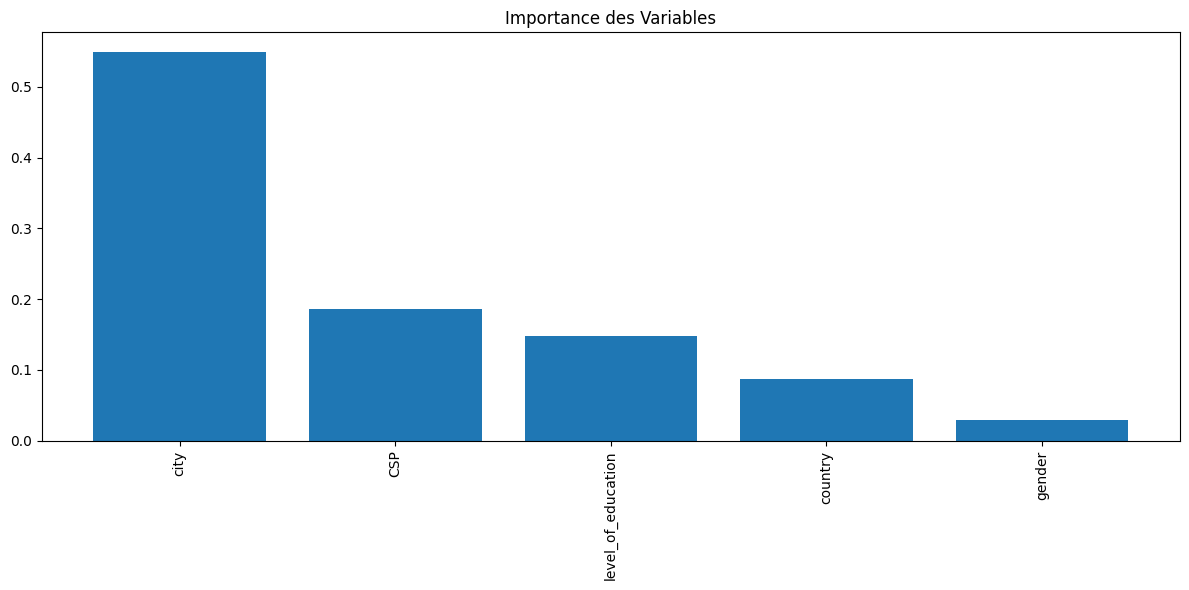

In [219]:
import numpy as np

# Importance des variables
importances = best_model_classifier.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_classifier.columns

# Visualisation de l'importance des variables
plt.figure(figsize=(12, 6))
plt.title("Importance des Variables")
plt.bar(range(X_classifier.shape[1]), importances[indices], align="center")
plt.xticks(range(X_classifier.shape[1]), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

In [139]:
# Pour prédire le grade pour de nouvelles données
def predict_grade(new_data, model, encoders):
    new_data_encoded = new_data.copy()
    for column in ['level_of_education', 'CSP', 'country', 'gender']:
        new_data_encoded[column + '_encoded'] = encoders[column].transform(new_data_encoded[column])
    X_new = new_data_encoded.drop(columns=['city', 'year_of_birth', 'cours', 'level_of_education', 'CSP', 'country', 'gender'])
    return model.predict(X_new)

new_data = pd.DataFrame({
    'country': ['FR'],
    'gender': ['f'],
    'level_of_education': ['hs'],
    'CSP': ['Cadre, sup'],
    'year_of_birth' : [1980],
    'city' : ['Paris'],
    'cours' : ['04021'],
    'datagiven' : [7]
})

# Prédire le grade pour les nouvelles données
predicted_grade = predict_grade(new_data, model, label_encoders)
print(f"Predicted grade: {predicted_grade}")

NameError: name 'model' is not defined

In [225]:
# Fonction pour prédire si un utilisateur obtiendra son diplôme
def predict_user_diploma(user_data):
    # Créer un DataFrame pour les nouvelles données utilisateur
    user_df = pd.DataFrame([user_data])
    
    # Encoder les colonnes catégorielles
    for column in categorical_columns_classifier:
        encoder = label_encoders_classifier[column]
        user_df[column] = encoder.transform(user_df[column])
    
    
    # Assurez-vous que les colonnes sont dans le même ordre que celles utilisées pour entraîner le modèle
    user_df = user_df[X_classifier.columns]
    
    # Faire la prédiction
    prediction = best_model_classifier.predict(user_df)
    return prediction[0]

# Exemples de nouvelles données utilisateur
new_user_data = {
    'level_of_education': 'hs',  # Remplacez par une valeur encodée correcte
    'CSP': 'cadre, sup',                 # Remplacez par une valeur encodée correcte
    'country': 'fr',               # Remplacez par une valeur encodée correcte
    'gender': 'm',                  # Remplacez par une valeur encodée correcte
    'city': 'paris',                   # Remplacez par une valeur encodée correcte
}

# Prédire si l'utilisateur obtiendra son diplôme
will_get_diploma = predict_user_diploma(new_user_data)
print
print(will_get_diploma)
print(f"L'utilisateur obtiendra-t-il son diplôme ? {'Oui' if will_get_diploma == 'Y' else 'Non'}")

Y
L'utilisateur obtiendra-t-il son diplôme ? Oui


In [159]:
new_user_data

{'level_of_education': 'b',
 'CSP': 'Employé',
 'country': 'FR',
 'gender': 'f',
 'city': 'Paris',
 'year_of_birth': 1990,
 'cours': '04017',
 'datagiven': 4}